If you have the ERA5 data, wave analysis file, and model data collected in one directory and named as in All_figs_data_setup.ipynb, this notebook should be able to replicate Figure 3 in Bartusek et al., 2022, _Nat. Clim. Change_.

Sam Bartusek, 2021

## _Data setup notebook (~15 min)_

In [1]:
%run ./All_figs_data_setup.ipynb


/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 50.2s


./All_figs_data_setup.ipynb:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "cell_type": "markdown",


In [2]:
# Climatology over all of june–july

climspec = xr.open_mfdataset(glob.glob(path + 'ERA5*19812010clim*nh.nc'),combine='by_coords')
climspec['t2m'] = climspec.t2m - 273.15
climspec['t2mland'] = climspec.t2m.where(landmask>.5)
climspec['skt'] = climspec.skt - 273.15
climspec['sktland'] = climspec.skt.where(landmask>.5)
climspec['z'] = climspec.z / 9.81
climspec['swvl1'] = climspec.swvl1.where(landmask>.5)
climspec['speed'] = (climspec.u**2 + climspec.v**2)**(1/2)
climspec = climspec.drop('time_bnds')
climspec
climspec['time'] = (climspec.time.to_pandas() + pd.offsets.DateOffset(years=11)).values


# Calculate daily-mean anomalies over all of June–July up to 2020

test = rawto20[['sktland','swvl1','t2mland','z']].sel(time=(rawto20.time.dt.month == 6) | (rawto20.time.dt.month == 7))
test.coords['time'] = test.time.dt.floor('1D')
test = test.groupby('time').mean()
month_day_str_raw = xr.DataArray(test.indexes['time'].strftime('%m-%d'), coords=test.time.coords)
test['month_day_str'] = month_day_str_raw

temp = climspec[['sktland','swvl1','t2mland','z']].sel(time=(climspec.time.dt.month == 6) | (climspec.time.dt.month == 7)).resample(time='1D').mean()
month_day_str_clim = xr.DataArray(temp.indexes['time'].strftime('%m-%d'), coords=temp.time.coords)
temp['month_day_str'] = month_day_str_clim
anomsliceto20 = test.groupby('month_day_str') - temp.groupby('month_day_str').mean()


# Take spatial mean over PNW

with pbar:
    anomsliceto20_pnw_mean = anomsliceto20.sel(latitude=pnwlat,longitude=pnwlon).weighted(weights).mean(('latitude','longitude')).compute()


[                                        ] | 0% Completed |  4.3s

/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  3min 24.1s


In [3]:
# Take June means over PNW up to 2020

test = rawto20[['sktland','swvl1','t2mland','z']].sel(time=(rawto20.time.dt.month == 6)).resample(time='1Y').mean()
test['time'] = pd.date_range(start='1979-06', periods=42, freq='12M')
anomjunto20 = test.groupby('time.month') - clim[['sktland','swvl1','t2mland','z']].sel(time=(clim.time.dt.month == 6)).resample(time='1M').mean().groupby('time.month').mean()
with pbar:
    anomjunto20_pnw_mean = anomjunto20.sel(latitude=pnwlat,longitude=pnwlon).weighted(weights).mean(('latitude','longitude')).compute()


[                                        ] | 0% Completed |  2.6s

/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 14.7s


In [4]:
# Select date range within June–July

junelim = 23-1   #23-1  #1   (i.e., select days >= to this date)   (if calculating 3-day means for partial month specify one day outside the desired range)
julylim = 5+1   #5+1  #31   (i.e., select days <= to this date)   (if calculating 3-day means for partial month specify one day outside the desired range)
timeslice = slice(f'2021-06-{junelim}',f'2021-07-{julylim}') 
tt = ((anomsliceto20_pnw_mean.time.dt.month == 6) & (anomsliceto20_pnw_mean.time.dt.day >= junelim)) | ((anomsliceto20_pnw_mean.time.dt.month == 7) & (anomsliceto20_pnw_mean.time.dt.day <= julylim))


# Select time-averaging window

days = 3


# Separate into historical periods

qq79 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1979','1999')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq00 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('2000','2020')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq81 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1981','2010')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq91 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1991','2020')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq20 = anomsliceto20_pnw_mean.sel(time=tt).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq21 = anomdaily_pnw_mean.sel(time=timeslice).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq = xr.merge([qq20,qq21])
eventlim = ((qq21.time.dt.month==6) & (qq21.time.dt.day>=23)) | ((qq21.time.dt.month==7) & (qq21.time.dt.day<=5))


# Calculate correlations between variables

_,ztcor,ztslope,ztint,ztpval,ztsterr = lag_linregress_3D(qq20.z,qq20.t2mland)
_,ztcor79,ztslope79,ztint79,ztpval79,ztsterr79 = lag_linregress_3D(qq79.z,qq79.t2mland)
_,ztcor00,ztslope00,ztint00,ztpval00,ztsterr00 = lag_linregress_3D(qq00.z,qq00.t2mland)

_,stcor,stslope,stint,stpval,ststerr = lag_linregress_3D(qq20.swvl1,qq20.t2mland)
_,stcor79,stslope79,stint79,stpval79,ststerr79 = lag_linregress_3D(qq79.swvl1,qq79.t2mland)
_,stcor00,stslope00,stint00,stpval00,ststerr00 = lag_linregress_3D(qq00.swvl1,qq00.t2mland)

_,szcor,szslope,szint,szpval,szsterr = lag_linregress_3D(qq20.swvl1,qq20.z)
_,szcor79,szslope79,szint79,szpval79,szsterr79 = lag_linregress_3D(qq79.swvl1,qq79.z)
_,szcor00,szslope00,szint00,szpval00,szsterr00 = lag_linregress_3D(qq00.swvl1,qq00.z)


# Calculate historical trends

dayssince20 = (qq20.time - qq20.time[0]).dt.days
t2mlandslope20,t2mlandint20,_,t2mlandpval20,_ = scipy.stats.linregress(dayssince20,qq20.t2mland)
zslope20,zint20,_,zpval20,_ = scipy.stats.linregress(dayssince20,qq20.z)
swvl1slope20,swvl1int20,_,swvl1pval20,_ = scipy.stats.linregress(dayssince20,qq20.swvl1)

dayssince81 = (qq81.time - qq81.time[0]).dt.days
t2mlandslope81,t2mlandint81,_,t2mlandpval81,_ = scipy.stats.linregress(dayssince81,qq81.t2mland)
zslope81,zint81,_,zpval81,_ = scipy.stats.linregress(dayssince81,qq81.z)
swvl1slope81,swvl1int81,_,swvl1pval81,_ = scipy.stats.linregress(dayssince81,qq81.swvl1)

dayssince91 = (qq91.time - qq91.time[0]).dt.days
t2mlandslope91,t2mlandint91,_,t2mlandpval91,_ = scipy.stats.linregress(dayssince91,qq91.t2mland)
zslope91,zint91,_,zpval91,_ = scipy.stats.linregress(dayssince91,qq91.z)
swvl1slope91,swvl1int91,_,swvl1pval91,_ = scipy.stats.linregress(dayssince91,qq91.swvl1)

dayssince00 = (qq00.time - qq00.time[0]).dt.days
t2mlandslope00,t2mlandint00,_,t2mlandpval00,_ = scipy.stats.linregress(dayssince00,qq00.t2mland)
zslope00,zint00,_,zpval00,_ = scipy.stats.linregress(dayssince00,qq00.z)
swvl1slope00,swvl1int00,_,swvl1pval00,_ = scipy.stats.linregress(dayssince00,qq00.swvl1)

dayssince = (qq.time - qq.time[0]).dt.days
t2mlandslope,t2mlandint,_,t2mlandpval,_ = scipy.stats.linregress(dayssince,qq.t2mland)
zslope,zint,_,zpval,_ = scipy.stats.linregress(dayssince,qq.z)
swvl1slope,swvl1int,_,swvl1pval,_ = scipy.stats.linregress(dayssince,qq.swvl1)

ts = tinv(0.1, len(qq79.t2mland)-2)


# Perform multiple linear regression

X = np.array((qq20.swvl1,qq20.z)).T
X21 = np.array((qq21.swvl1,qq21.z)).T
y = qq20.t2mland
reg = linear_model.LinearRegression().fit(X, y)

xx = np.arange(-.09,.09,.005)
yy = np.arange(-170,240,5)
xg,yg = np.meshgrid(xx,yy)

pps = reg.predict(np.vstack((xg.ravel(),yg.ravel())).T).reshape(xg.shape)
pp20 = reg.predict(np.array((qq20.swvl1,qq20.z)).T)
pp21 = reg.predict(np.array((qq21.swvl1,qq21.z)).T)
pp = reg.predict(np.array((qq.swvl1,qq.z)).T)


## _3a–d)_

/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

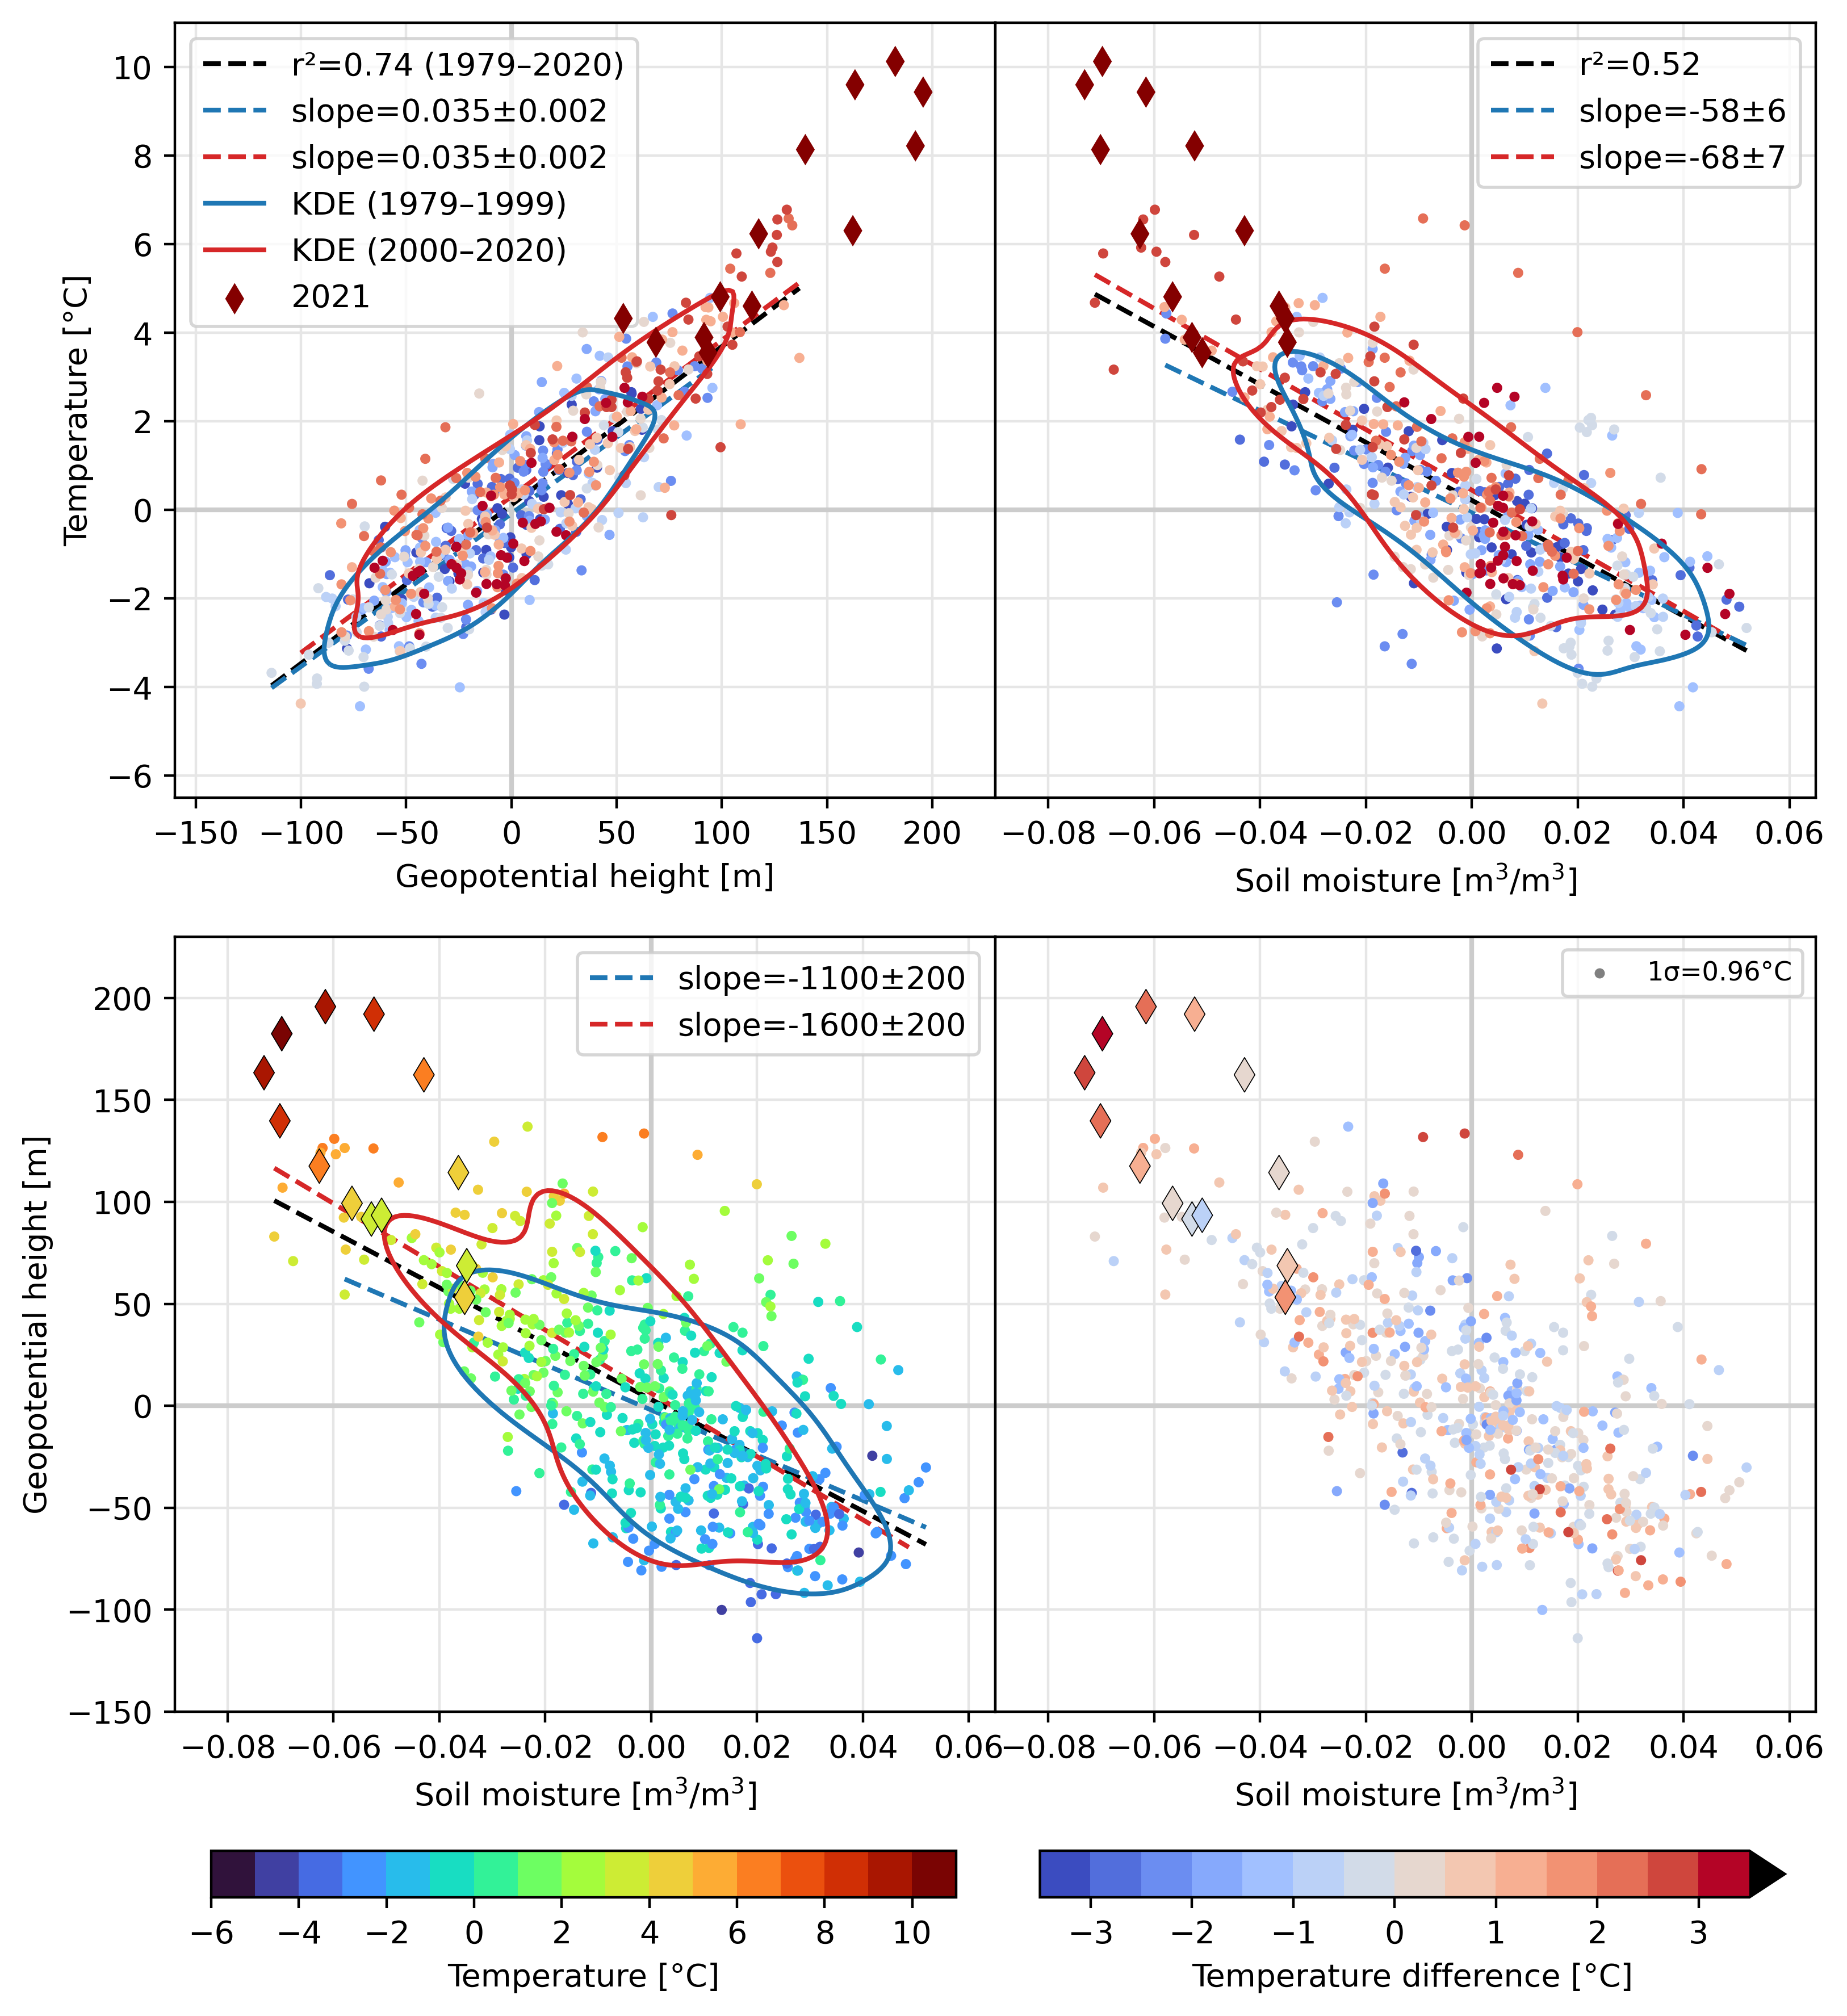

In [12]:
# Plot

fig,axs = plt.subplots(2,2,figsize=(8.2,8.2),dpi=200,sharey='row',gridspec_kw={'wspace':0})
axs = axs.reshape(-1)
cmap1 = cm.get_cmap('coolwarm',14)

ss = 20    # circle sizes
ss21 = 60    # diamond sizes

####### scatters colored by year #######
ax = axs[0]
ax.axvline(0,c='.8')
ax.axhline(0,c='.8')
ax.grid(c='.9')
cc = ax.scatter(qq20.z,qq20.t2mland,c=qq20.time.dt.year,cmap=cmap1,vmax=2021,marker='.',s=ss,alpha=1,zorder=201)
xx = np.linspace(qq20.z.min(),qq20.z.max())
ax.plot(xx,ztslope.values*xx+ztint.values,ls='--',color='0',label=f'r\N{superscript two}={np.round(ztcor.values**2,2)} (1979–2020)',zorder=100)
sns.kdeplot(qq79.z,qq79.t2mland,ax=ax,levels=[.3],linewidths=1.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='tab:blue',label='KDE (1979–1999)')
xx = np.linspace(qq79.z.min(),qq79.z.max())
ax.plot(xx,ztslope79.values*xx+ztint79.values,ls='--',color='tab:blue',label=f'slope={np.round(ztslope79.values,3)}±{np.round(ts*ztsterr79.values,3)}',zorder=101)
sns.kdeplot(qq00.z,qq00.t2mland,ax=ax,levels=[.3],linewidths=1.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='tab:red',label='KDE (2000–2020)')
xx = np.linspace(qq00.z.min(),qq00.z.max())
ax.plot(xx,ztslope00.values*xx+ztint00.values,ls='--',color='tab:red',label=f'slope={np.round(ztslope00.values,3)}±{np.round(ts*ztsterr00.values,3)}',zorder=102)#,label=f'r={np.round(ztcor00.values,2)}',zorder=101)
ax.scatter(qq21.where(eventlim,drop=True).z,qq21.where(eventlim,drop=True).t2mland,marker='d',facecolor='xkcd:dark red',edgecolor='none',s=ss21*5/6,alpha=1,zorder=401,label='2021')
ax.set_xlim(-160,230)
ax.set_ylim(-6.5,11)
ax.legend(loc='upper left')
ax.set_title('')
ax.set_ylabel('Temperature [°C]')
ax.set_xlabel('Geopotential height [m]')

ax = axs[1]
ax.axvline(0,c='.8')
ax.axhline(0,c='.8')
ax.grid(c='.9')
cc = ax.scatter(qq20.swvl1,qq20.t2mland,c=qq20.time.dt.year,cmap=cmap1,vmax=2021,marker='.',s=ss,alpha=1,zorder=201)
xx = np.linspace(qq20.swvl1.min(),qq20.swvl1.max())
ax.plot(xx,stslope.values*xx+stint.values,ls='--',color='0',label=f'r\N{superscript two}={np.round(stcor.values**2,2)}',zorder=100)
sns.kdeplot(qq79.swvl1,qq79.t2mland,ax=ax,levels=[.3],linewidths=1.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='tab:blue')
xx = np.linspace(qq79.swvl1.min(),qq79.swvl1.max())
ax.plot(xx,stslope79.values*xx+stint79.values,ls='--',color='tab:blue',label=f'slope={int(np.round(stslope79.values,0))}±{int(np.round(ts*ststerr79.values,0))}',zorder=101)
sns.kdeplot(qq00.swvl1,qq00.t2mland,ax=ax,levels=[.3],linewidths=1.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='tab:red')
xx = np.linspace(qq00.swvl1.min(),qq00.swvl1.max())
ax.plot(xx,stslope00.values*xx+stint00.values,ls='--',color='tab:red',label=f'slope={int(np.round(stslope00.values,0))}±{int(np.round(ts*ststerr00.values,0))}',zorder=102)#,label=f'r={np.round(stcor00.values,2)}',zorder=101)
ax.scatter(qq21.where(eventlim,drop=True).swvl1,qq21.where(eventlim,drop=True).t2mland,marker='d',facecolor='xkcd:dark red',edgecolor='none',s=ss21*5/6,alpha=1,zorder=401)
ax.set_xlim(-.09,.065)
ax.legend(loc='upper right')
ax.set_title('')
ax.set_ylabel('')
ax.tick_params(axis='y',length=0)
ax.set_xlabel('Soil moisture [m$^3$/m$^3$]')

# cbar_ax = fig.add_axes([.31, .46, 0.4, 0.025])#[1, 0.57, 0.025, 0.33]
# cb = fig.colorbar(cc,cax=cbar_ax,orientation='horizontal')
# cb.set_label('')
####### end #######

####### scatter colored by temperature #######
cmap1 = cm.get_cmap('turbo',17)
# cmap1 = cm.get_cmap('inferno',17)

ax = axs[2]
ax.axvline(0,c='.8',alpha=1)
ax.axhline(0,c='.8',alpha=1)
ax.grid(c='.9',alpha=1)
cc = ax.scatter(qq20.swvl1,qq20.z,c=qq20.t2mland,cmap=cmap1,vmax=11,vmin=-6,marker='.',s=ss,zorder=201)
xx = np.linspace(qq20.swvl1.min(),qq20.swvl1.max())
ax.plot(xx,szslope.values*xx+szint.values,ls='--',color='0',label='',zorder=100)#f'r={np.round(zscor.values,2)}',zorder=100)
sns.kdeplot(qq79.swvl1,qq79.z,ax=ax,levels=[.3],linewidths=1.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='tab:blue')#,label='KDE (1979–1999)')
xx = np.linspace(qq79.swvl1.min(),qq79.swvl1.max())
ax.plot(xx,szslope79.values*xx+szint79.values,ls='--',color='tab:blue',label=f'slope={int(np.round(szslope79.values,-2))}±{int(np.round(ts*szsterr79.values,-2))}',zorder=101)
sns.kdeplot(qq00.swvl1,qq00.z,ax=ax,levels=[.3],linewidths=1.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='tab:red')#,label='KDE (2000–2020)')
xx = np.linspace(qq00.swvl1.min(),qq00.swvl1.max())
ax.plot(xx,szslope00.values*xx+szint00.values,ls='--',color='tab:red',label=f'slope={int(np.round(szslope00.values,-2))}±{int(np.round(ts*szsterr00.values,-2))}',zorder=102)
cc2 = ax.scatter(qq21.where(eventlim,drop=True).swvl1,qq21.where(eventlim,drop=True).z,c=qq21.where(eventlim,drop=True).t2mland,cmap=cmap1,vmax=11,vmin=-6,marker='d',s=ss21,edgecolor='0',linewidth=.3,ls='-',zorder=401)
ax.legend(loc='upper right')
ax.set_xlim(-.09,.065)
ax.set_ylim(-150,230)
ax.set_title('')
ax.set_ylabel('Geopotential height [m]')
ax.set_xlabel('Soil moisture [m$^3$/m$^3$]')

cbar_ax = fig.add_axes([.12, -.025, 0.4, 0.025])
cb = fig.colorbar(cc,cax=cbar_ax,ticks=np.arange(-6,12,2),orientation='horizontal')
cb.set_label('Temperature [°C]')
####### end #######

# ####### scatter colored by temperature with predicted values in contourf #######
# # cmap1 = cm.get_cmap('inferno')
# cmap1 = cm.get_cmap('turbo')

# ax = axs[3]
# ax.axvline(0,c='.8')
# ax.axhline(0,c='.8')
# ax.grid(c='.9',alpha=.2,ls='-')
# cc = ax.contourf(xg,yg,pps,cmap=cmap1,levels=np.linspace(-6,11,100))
# cc1 = ax.scatter(qq20.swvl1,qq20.z,c=qq20.t2mland,cmap=cmap1,vmax=11,vmin=-6,marker='.',s=ss,zorder=101)
# cc2 = ax.scatter(qq21.where(eventlim,drop=True).swvl1,qq21.where(eventlim,drop=True).z,c=qq21.where(eventlim,drop=True).t2mland,cmap=cmap1,vmax=11,vmin=-6,marker='d',s=ss21+10,edgecolor='none',linewidth=.3,ls='-',zorder=101)
# ax.set_xlim(-.09,.065)
# ax.set_title('')
# ax.set_ylabel('')
# ax.tick_params(axis='y',length=0)
# ax.set_xlabel('Soil moisture [m$^3$/m$^3$]')

# cbar_ax = fig.add_axes([.565, -.025, 0.4, 0.025])
# cb = fig.colorbar(cc,cax=cbar_ax,orientation='horizontal',ticks=np.arange(-6,12,2))
# cb.set_label('Temperature [°C]')
# ####### end #######

####### scatter colored by difference from predicted #######
cmap1 = cm.get_cmap('coolwarm',14)

ax = axs[3]
ax.axvline(0,c='.8',alpha=1)
ax.axhline(0,c='.8',alpha=1)
ax.grid(c='.9',alpha=1)
cc1 = ax.scatter(qq20.swvl1,qq20.z,c=(qq20.t2mland - pp20),cmap=cmap1,vmax=3.5,vmin=-3.5,marker='.',s=ss,zorder=101)
cc2 = ax.scatter(qq21.where(eventlim,drop=True).swvl1,qq21.where(eventlim,drop=True).z,c=(qq21.where(eventlim,drop=True).t2mland - pp21[eventlim.values]),cmap=cmap1,vmax=3.5,vmin=-3.5,marker='d',s=ss21,edgecolor='0',linewidth=.3,ls='-',zorder=101)
ax.scatter([],[],marker='.',s=ss,color='.5',label=f'1σ={np.round((qq20.t2mland - pp20).std().values,2)}°C')
ax.set_xlim(-.09,.065)
ax.legend(loc='upper right',fontsize='small')
ax.set_title('')
ax.set_ylabel('')
ax.tick_params(axis='y',length=0)
ax.set_xlabel('Soil moisture [m$^3$/m$^3$]')

cmap = cc1.get_cmap()
cmap.set_over('0')
cc1.set_cmap(cmap)

cbar_ax = fig.add_axes([.565, -.025, 0.4, 0.025])
cb = fig.colorbar(cc1,cax=cbar_ax,extend='max',orientation='horizontal')
cb.set_label('Temperature difference [°C]')
####### end #######

plt.tight_layout()


## _3e–g)_

Text(0.5, 0, '')

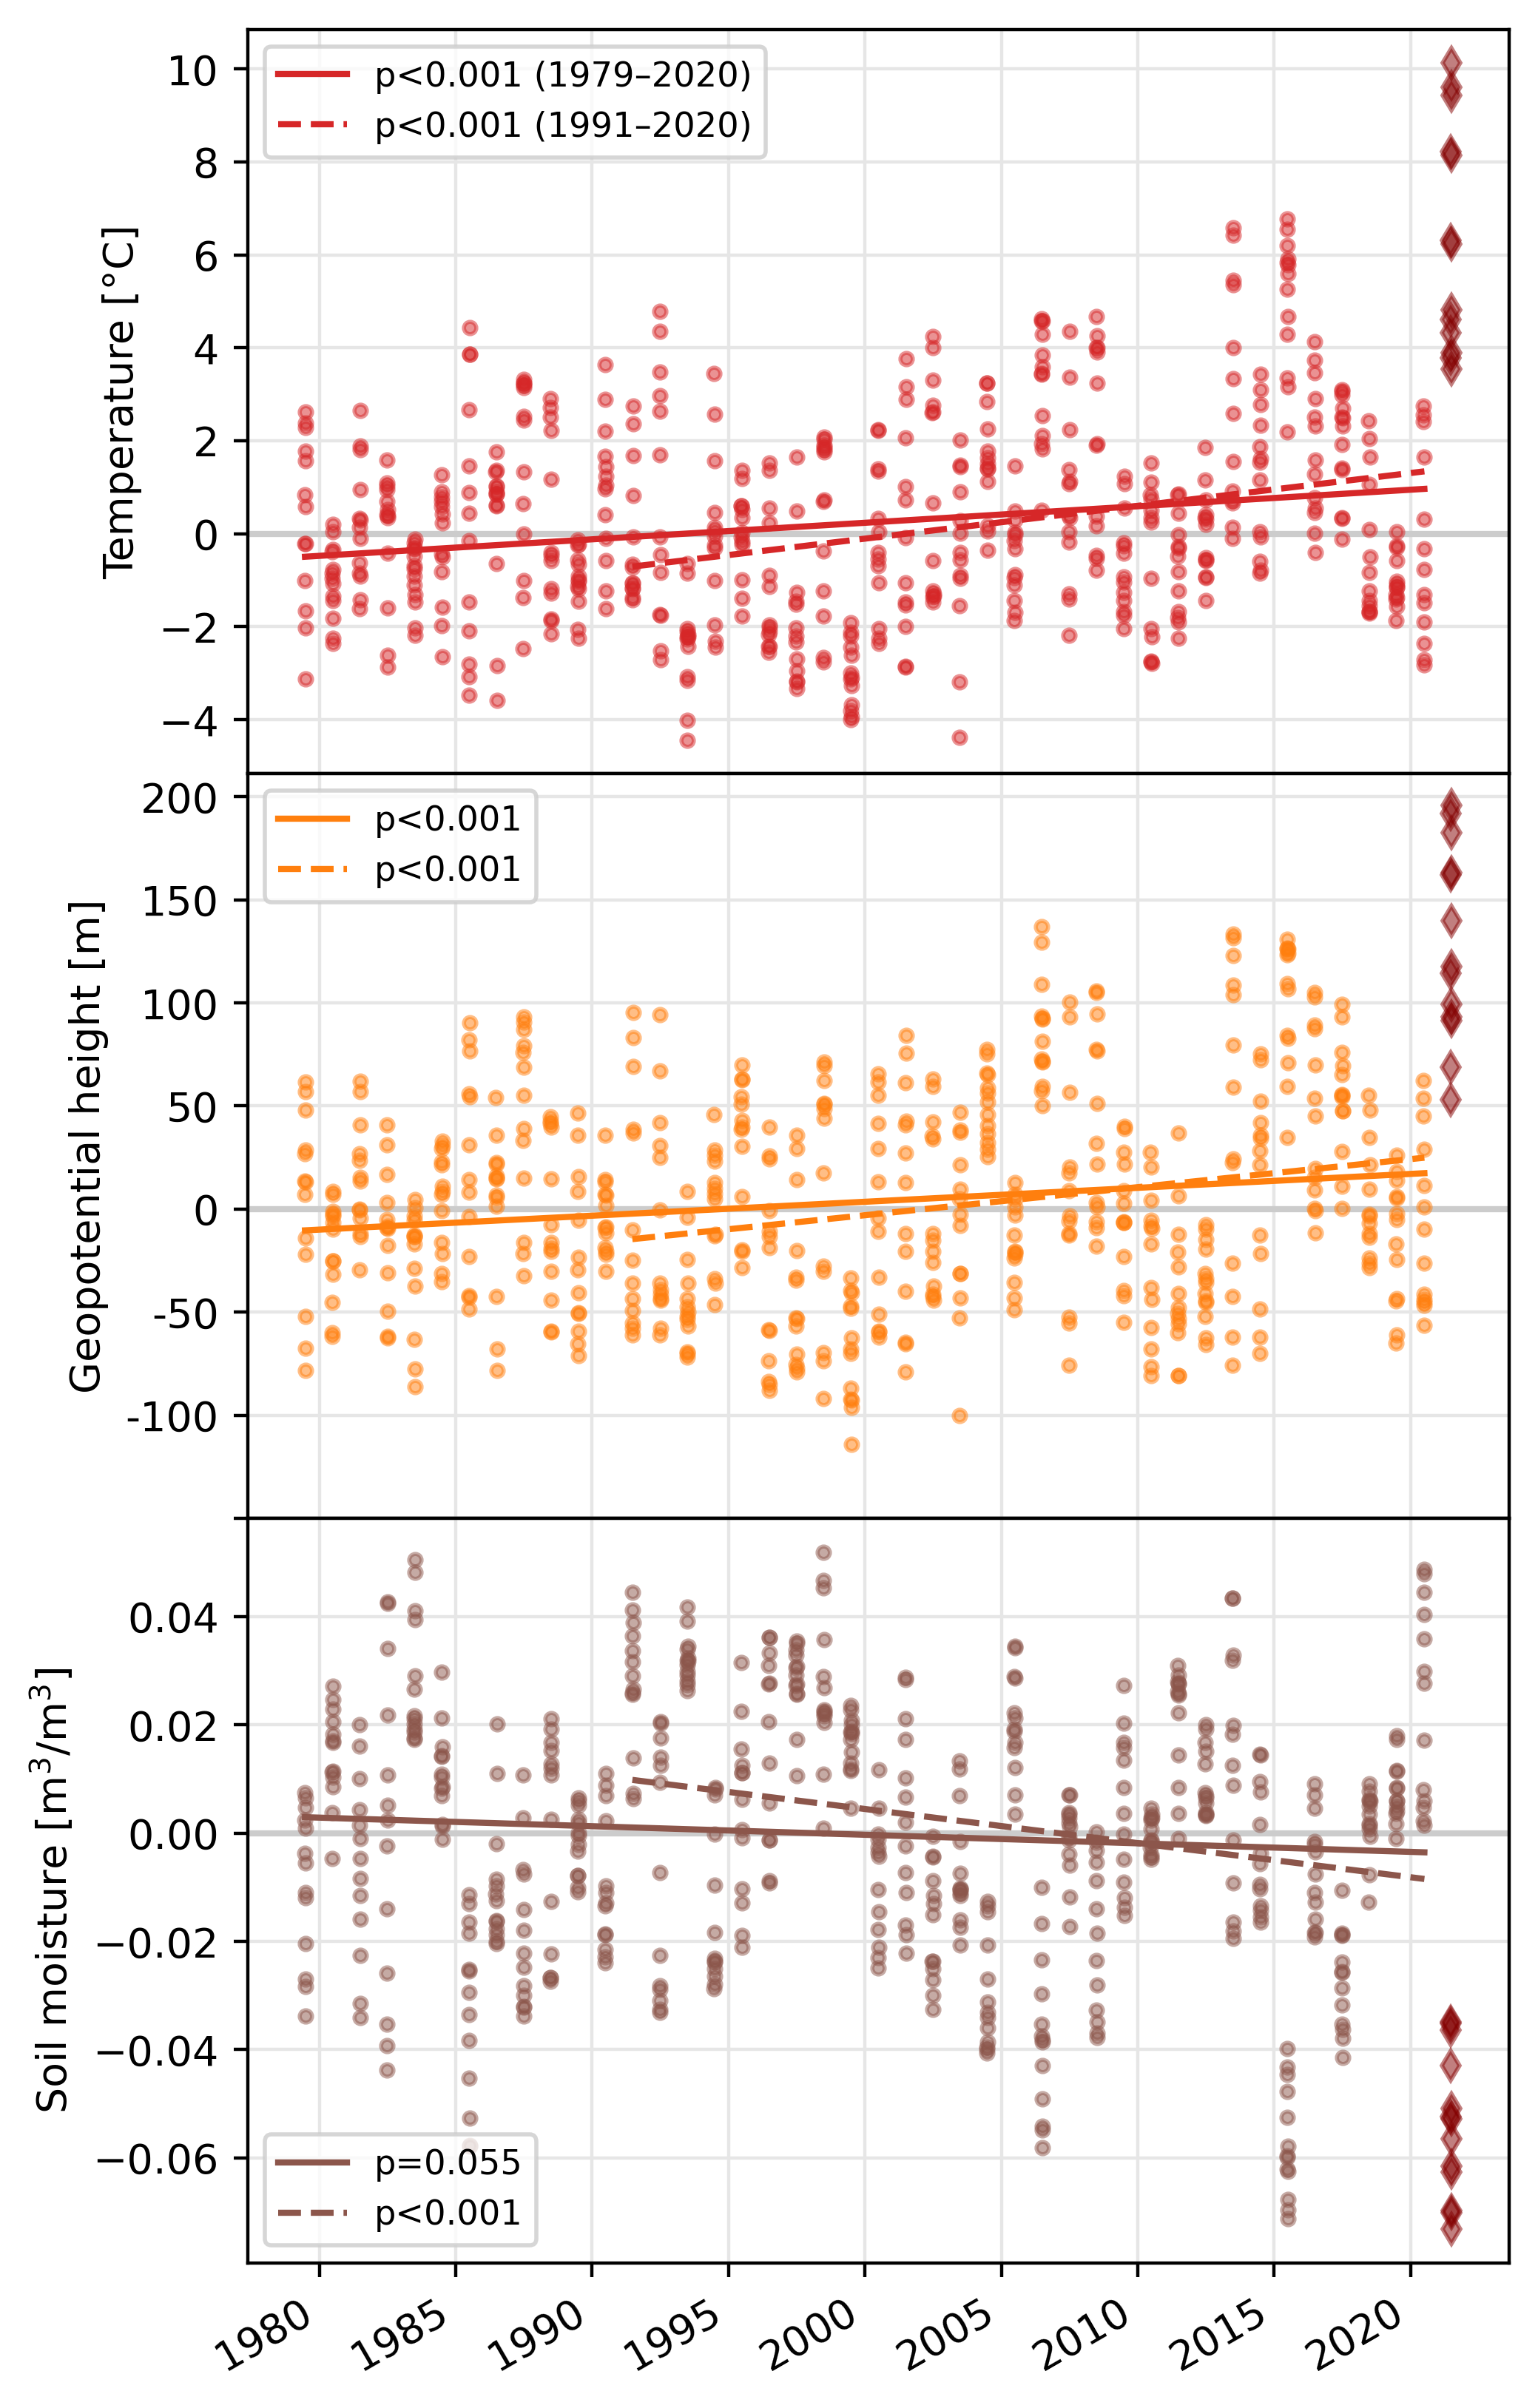

In [25]:
# Plot

fig,axs = plt.subplots(3,1,figsize=(5.5,10),dpi=200,sharex=True,gridspec_kw={'hspace':0.00})

ax = axs[0]
ax.axhline(0,c='.8')
ax.grid(c='.9')
qq20.t2mland.plot(ax=ax,marker='.',ls='',alpha=.5,color='tab:red')
qq21.t2mland.plot(ax=ax,marker='d',ls='',markersize=5,alpha=.5,color='xkcd:dark red')
ax.plot(qq20.time,t2mlandslope20*dayssince20+t2mlandint20,ls='-',color='tab:red',label=f'p<{np.max((round_to_n(t2mlandpval20,2),.001))} (1979–2020)')
ax.plot(qq91.time,t2mlandslope91*dayssince91+t2mlandint91,ls='--',color='tab:red',label=f'p<{np.max((round_to_n(t2mlandpval91,2),.001))} (1991–2020)')
ax.legend(fontsize='small')
ax.set_ylabel('Temperature [°C]')
ax.set_xlabel('')

ax = axs[1]
ax.axhline(0,c='.8')
ax.grid(c='.9')
qq20.z.plot(ax=ax,marker='.',ls='',alpha=.5,color='tab:orange')
qq21.z.plot(ax=ax,marker='d',ls='',markersize=5,alpha=.5,color='xkcd:dark red')
ax.plot(qq20.time,zslope20*dayssince20+zint20,ls='-',color='tab:orange',label=f'p<{np.max((round_to_n(zpval20,2),.001))}')
ax.plot(qq91.time,zslope91*dayssince91+zint91,ls='--',color='tab:orange',label=f'p<{np.max((round_to_n(zpval91,2),.001))}')
ax.legend(fontsize='small')
ax.set_ylabel('Geopotential height [m]')
ax.set_xlabel('')
ax.set_yticks([-150,-100,-50,0,50,100,150,200])
ax.set_yticklabels(['','-100','-50','0','50','100','150','200'])

ax = axs[2]
ax.axhline(0,c='.8')
ax.grid(c='.9')
qq20.swvl1.plot(ax=ax,marker='.',ls='',alpha=.5,color='tab:brown')
qq21.swvl1.plot(ax=ax,marker='d',ls='',markersize=5,alpha=.5,color='xkcd:dark red')
ax.plot(qq20.time,swvl1slope20*dayssince20+swvl1int20,ls='-',color='tab:brown',label=f'p={np.max((round_to_n(swvl1pval20,2),.001))}')
ax.plot(qq91.time,swvl1slope91*dayssince91+swvl1int91,ls='--',color='tab:brown',label=f'p<{np.max((round_to_n(swvl1pval91,2),.001))}')
ax.legend(loc='lower left',fontsize='small')
ax.set_ylabel('Soil moisture [m$^3$/m$^3$]')
ax.set_xlabel('')
